<a href="https://colab.research.google.com/github/Momilijaz96/AlphaFold-V1-PyTorch/blob/main/DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download weights and test data
!if [ ! -f alphafold-casp13-weights.zip ]; then wget -O alphafold-casp13-weights.zip http://bit.ly/alphafold-casp13-weights; fi;
!if [ ! -f t0958.zip ]; then wget -O t0958.zip https://www.dropbox.com/s/l9yp92vtjsoj7qk/T0958.zip?dl=0&file_subpath=%2FT0958%2FT0958.tfrec; fi;

# Unzip files
!if [ ! -d alphafold-casp13-weights ]; then unzip -a alphafold-casp13-weights.zip -d alphafold-casp13-weights; fi;
!if [ ! -d alphafold-casp13-data ]; then unzip -a t0958.zip -d alphafold-casp13-data; fi;

In [ ]:
import tensorflow as tf
import collections
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches


## Step1: Features and tfrec
Define feature names and declare functions<br>

a. For reading the tfrec files, as the protien data is given in that file format.<br>
b. For converting tfrec to pickle

In [ ]:
NUM_RES = 'sequence_length_placeholder' 
#Assuming NUM_RES is 128 then we can tell which features are 1d or 2d
FEATURES = {
    'aatype': ('float32', [NUM_RES, 21]), 
    'alpha_mask': ('int64', [NUM_RES, 1]), 
    'alpha_positions': ('float32', [NUM_RES, 3]), 
    'beta_mask': ('int64', [NUM_RES, 1]), 
    'beta_positions': ('float32', [NUM_RES, 3]), 
    'between_segment_residues': ('int64', [NUM_RES, 1]), 
    'chain_name': ('string', [1]), #?
    'deletion_probability': ('float32', [NUM_RES, 1]), 
    'domain_name': ('string', [1]), #?
    'gap_matrix': ('float32', [NUM_RES, NUM_RES, 1]), 
    'hhblits_profile': ('float32', [NUM_RES, 22]), 
    'hmm_profile': ('float32', [NUM_RES, 30]), 
    #'key': ('string', [1]),
    'mutual_information': ('float32', [NUM_RES, NUM_RES, 1]), 
    'non_gapped_profile': ('float32', [NUM_RES, 21]), 
    'num_alignments': ('int64', [NUM_RES, 1]), 
    'num_effective_alignments': ('float32', [1]), #scalar
    'phi_angles': ('float32', [NUM_RES, 1]), 
    'phi_mask': ('int64', [NUM_RES, 1]), 
    'profile': ('float32', [NUM_RES, 21]), 
    'profile_with_prior': ('float32', [NUM_RES, 22]),
    'profile_with_prior_without_gaps': ('float32', [NUM_RES, 21]), 
    'pseudo_bias': ('float32', [NUM_RES, 22]), 
    'pseudo_frob': ('float32', [NUM_RES, NUM_RES, 1]), 
    'pseudolikelihood': ('float32', [NUM_RES, NUM_RES, 484]), 
    'psi_angles': ('float32', [NUM_RES, 1]), 
    'psi_mask': ('int64', [NUM_RES, 1]), 
    'residue_index': ('int64', [NUM_RES, 1]), 
    'resolution': ('float32', [1]), #scalar
    'reweighted_profile': ('float32', [NUM_RES, 22]), 
    'sec_structure': ('int64', [NUM_RES, 8]), 
    'sec_structure_mask': ('int64', [NUM_RES, 1]), 
    'seq_length': ('int64', [NUM_RES, 1]), 
    'sequence': ('string', [1]), #?
    'solv_surf': ('float32', [NUM_RES, 1]), 
    'solv_surf_mask': ('int64', [NUM_RES, 1]), 
    'superfamily': ('string', [1]), #?
}

We have almost 17 2d features with varying channels and sizes, 13 1d or vector features and few strings.

In [ ]:
#Create a named tuple / dictionary for each data sample i.e. protien sequence
Protein = collections.namedtuple('Protein', ['len', 'seq', 'inputs_1d', 'inputs_2d', 'inputs_2d_diagonal', 'scalars', 'targets'])


In [ ]:
FEATURE_TYPES = {k: v[0] for k, v in FEATURES.items()}
FEATURE_SIZES = {k: v[1] for k, v in FEATURES.items()}

def shape(feature_name, num_residues, features=None):
  """Get the shape for the given feature name.
  Args:
    feature_name: String identifier for the feature. If the feature name ends
      with "_unnormalized", theis suffix is stripped off.
    num_residues: The number of residues in the current domain - some elements
      of the shape can be dynamic and will be replaced by this value.
    features: A feature_name to (tf_dtype, shape) lookup; defaults to FEATURES.
  Returns:
    List of ints representation the tensor size.
  """
  features = features or FEATURES
  if feature_name.endswith('_unnormalized'):
    feature_name = feature_name[:-13]

  unused_dtype, raw_sizes = features[feature_name]
  replacements = {NUM_RES: num_residues}

  sizes = [replacements.get(dimension, dimension) for dimension in raw_sizes]
  return sizes


def parse_tfexample(raw_data, features):
  """Read a single TF Example proto and return a subset of its features.
  Args:
    raw_data: A serialized tf.Example proto.
    features: A dictionary of features, mapping string feature names to a tuple
      (dtype, shape). This dictionary should be a subset of
      protein_features.FEATURES (or the dictionary itself for all features).
  Returns:
    A dictionary of features mapping feature names to features. Only the given
    features are returned, all other ones are filtered out.
  """
  feature_map = {
      k: tf.io.FixedLenSequenceFeature(shape=(), dtype=v[0], allow_missing=True)
      for k, v in features.items()
  }
  parsed_features = tf.io.parse_single_example(raw_data, feature_map)

  # Find out what is the number of sequences and the number of alignments.
  num_residues = tf.cast(parsed_features['seq_length'][0], dtype=tf.int32)

  # Reshape the tensors according to the sequence length and num alignments.
  for k, v in parsed_features.items():
    new_shape = shape(feature_name=k, num_residues=num_residues)
    # Make sure the feature we are reshaping is not empty.
    assert_non_empty = tf.assert_greater(
        tf.size(v), 0, name='assert_%s_non_empty' % k,
        message='The feature %s is not set in the tf.Example. Either do not '
        'request the feature or use a tf.Example that has the feature set.' % k)
    with tf.control_dependencies([assert_non_empty]):
      parsed_features[k] = tf.reshape(v, new_shape, name='reshape_%s' % k)

  return parsed_features


def tfrec_read(tf_record_filename, features):
  """Creates an instance of tf.data.Dataset backed by a protein dataset SSTable.
  Args:
    tf_record_filename: A string with filename of the TFRecord file.
    features: A list of strings of feature names to be returned in the dataset.
  Returns:
    A tf.data.Dataset object. Its items are dictionaries from feature names to
    feature values.
  """
  # Make sure these features are always read.
  required_features = ['aatype', 'sequence', 'seq_length']
  features = list(set(features) | set(required_features))
  features = {name: FEATURES[name] for name in features}

  tf_dataset = tf.data.TFRecordDataset(filenames=[tf_record_filename])
  tf_dataset = tf_dataset.map(lambda raw: parse_tfexample(raw, features))

  return tf_dataset

In [ ]:
#TFrec to pickle 
def tfrec2pkl(dataset, pkl_file):
    datalist = []
    dataset = dataset.batch(1)
    for x in dataset:
        data = {}
        for k, v in x.items():
            if k in ['sequence', 'domain_name', 'chain_name', 'resolution', 'superfamily', 'num_effective_alignments']:
                # print(f"{k}: {v.numpy()[0,0].decode('utf-8')}")
                if v.numpy().dtype == 'O':
                    data[k] = v.numpy()[0,0].decode('utf-8')
                else:
                    data[k] = v.numpy()[0,0]
            else:
                # print(k, v.numpy().shape)
                data[k] = v.numpy()[0]
        datalist.append(data)

    with open(pkl_file, 'wb') as f:
        pickle.dump(datalist, f)

    return datalist

## Step2:  Feature Prcessor
Define a feature processor class and add all steps of featuer processing to it as functions.<br>
a. Read a tfrec file.<br>
b. Convert the tfrec file to pickle.<br>
c. Normalize the picked data.<br>
d. Group the normalized features by dimension by function group_by_dim.<br>


In [ ]:
class FeatureProcessor():
  """
  Feature processor class performs feature processing given tfrec and config gile
  class variables:
    config = configuration dict
    tfrec_filename = Target tfrec file  path, to process
    features = Features to read from the tfrec file
    targets = targets from config
    scalars = scalars from config
    copy_normalized_features = list of normalized features ?
    normalized_features = features to be normalized
  """
  #Constructor
  def __init__(self,tfrec_filename,config,stats_filename):
    self.config=config
    self.tfrec_filename=tfrec_filename
    network_config=config['network_config']
    self.features=network_config['features']
    self.targets=config['network_config']['targets']
    self.scalars=config['network_config']['scalars']
    self.config=config
    #Read Stats file
    with tf.io.gfile.GFile(stats_filename, 'r') as f:
      self.normalization_stats = json.load(f)
    


  #Function to read tfrec file
  def read_tfrec(self):
    raw_datset=tfrec_read(self.tfrec_filename,self.features)
    return raw_dataset
  
  #Function to convert tfrec to pickle
  def tfrec_to_pickle(self,raw_dataset):
    dataset=tfrec2pkl(raw_dataset,self.tfrec_filename[:-5]+'pkl')
    return dataset
  
  #Function normalized the dataset
  def normalize(self,data_sample):
    feature_normalization = {k: self.config['feature_normalization'] for k in self.features if k not in self.config['normalization_exclusion']}
    copy_unnormalized = list(set(self.features) & set(self.targets))
    
    for k in copy_unnormalized:
        if k in data_sample: data_sample[f'{k}_unnormalized'] = data_sample[k]
    
    range_epsilon = 1e-12
    for k, v in data_sample.items():
        if k not in feature_normalization or feature_normalization[k] == 'none': pass
        elif feature_normalization[k] == 'std':
            train_range = np.sqrt(np.float32(self.normalization_stats['var'][k]))
            v = v - np.float32(self.normalization_stats['mean'][k])
            v = v / train_range if train_range > range_epsilon else v
            data_sample[k] = v
        else:
            raise ValueError(f'Unknown normalization mode {feature_normalization[k]} for feature {k}.')

    return data_sample
  
  #Function to group the normzied features by dim
  def group_by_dim(self,data_sample):
    tensors_1d = []
    tensors_2d = []
    tensors_2d_diagonal = []
    L = len(data_sample['sequence'])

    #Get features
    features= self.features
    scalars = self.scalars
    targets = self.targets

    #Group features by dim into 1d and 2d lists and get a Protien tuple
    for k in features:
      dim = len(FEATURES[k][1]) - 1 #get feature dim
      if dim == 1:
          #print("1d feature:",k," with len: ",FEATURES[k][1])
          tensors_1d.append(np.float32(data_sample[k])) #appedn 1d features in a list
      elif dim == 2:
          #print("2d feature:",k," with len: ",FEATURES[k][1])
          if k not in data_sample: #if 2d feature not availble look for its crooped/diag version and append it
              if not(f'{k}_cropped' in data_sample and f'{k}_diagonal' in data_sample):
                raise ValueError(
                    f'The 2D feature {k} is not in the features dictionary and neither are its cropped and diagonal versions.')
              else:
                tensors_2d.append(np.float32(data_sample[f'{k}_cropped']))
                tensors_2d_diagonal.append(np.float32(data_sample[f'{k}_diagonal']))
          else:
              tensors_2d.append(np.float32(data_sample[k])) #othewise append original 2d feature
    
    inputs_1d = np.concatenate(tensors_1d, -1)
    inputs_2d = np.concatenate(tensors_2d, -1) if tensors_2d else np.zeros((L, L, 0), dtype=np.float32)

    if tensors_2d_diagonal:
        diagonal_crops1 = [t[:, :, :(t.shape[2] // 2)] for t in tensors_2d_diagonal]
        diagonal_crops2 = [t[:, :, (t.shape[2] // 2):] for t in tensors_2d_diagonal]
        inputs_2d_diagonal = np.concatenate(diagonal_crops1 + diagonal_crops2, 2)
    else:
        inputs_2d_diagonal = inputs_2d

    scalars = collections.namedtuple('ScalarClass', scalars)(*[data_sample.get(f'{k}_unnormalized', data_sample[k]) for k in scalars])
    targets = collections.namedtuple('TargetClass', targets)(*[data_sample.get(f'{k}_unnormalized', data_sample[k]) for k in targets])

    p = Protein(
              len=L,
              seq=data_sample['sequence'],
              inputs_1d=inputs_1d,
              inputs_2d=inputs_2d,
              inputs_2d_diagonal=inputs_2d_diagonal,
              scalars=scalars,
              targets=targets
          )
    return p

  #Function perform all above functions in order and get processed dataset
  def load_data(self,config):
    raw_dataset=self.read_tfrec() #a. read the tfrec file
    pkl_dataset=self.tfrec_to_pickle(raw_dataset) #b. pickel teh rawdataset
    dataset_norm=[self.normalize(data) for data in pkl_dataset] #normlalize each same from pickle dataset
    protien=[self.group_by_dim(data) for data in dataset_norm] #group by dim and get protien named tuple

    return protien



In [ ]:
####TEST THE FEATURE PROCESSOR CLASS#####

#Read a tfrec file
data_file='alphafold-casp13-data/T0958/T0958.tfrec'
raw_dataset = tfrec_read(data_file,FEATURES)
datalist=tfrec2pkl(raw_dataset,'T0958.pkl')

#Get the network configuration dictionary
import tensorflow as tf
import json
config_file_path = 'alphafold-casp13-weights/873731/0/config.json'

# Load the first distogram replica config file
with tf.io.gfile.GFile(config_file_path, 'r') as f:
  config = json.load(f)

#stats file name
stats_filename='/content/alphafold-casp13-weights/873731/stats_train_s35.json'

FP=FeatureProcessor(data_file,config,stats_filename)
p=FP.load_data(config)

In [ ]:
p[0].targets._asdict().keys()

odict_keys(['sec_structure', 'sec_structure_mask', 'solv_surf', 'solv_surf_mask', 'beta_positions', 'beta_mask', 'domain_name', 'chain_name', 'resolution', 'num_alignments', 'superfamily', 'profile', 'hhblits_profile', 'residue_index', 'between_segment_residues'])

In [ ]:
print("T0958 PROTIEN:")
for k in p[0]._asdict().keys():
  print(k)

T0958 PROTIEN:
len
seq
inputs_1d
inputs_2d
inputs_2d_diagonal
scalars
targets


## Step3: Mapping Inputs1d to 2d
Mapping 1d input features to 2d in following steps:<br>

1. Get residue_index and inputs1d from protien.
2. Get horizontal all colum D-channeled crops from inputs1d using crop_x and crop_y indices and pad them.
3. Get padded slices from residue_index using crop_x and crop_y.
4. Using binary code bits get b channeled slices from residue_index using crop_x and crop_y.
5. Reshape and tile them all.
6. Concatenate and give mapped features of size LxLx(2D+2b+2).

In [ ]:
#Function to map 1d features to 2d
def feature_1d_to_2d(inputs1d, res_idx, L, crop_x, crop_y, crop_size_x, crop_size_y, binary_code_bits):

  res_idx=np.int32(res_idx) #Map residue index to int
  range_scale=100.0
  n_x, n_y = crop_size_x, crop_size_y

  #Get a horizontal all column slice out of inputs1d matrix with some vertical padding
  #using crop_y indices
  #x_1d_y size LXD, where D is inputs_1d.shape[1]
  inputs1d_y = np.pad(
        inputs1d[max(0, crop_y[0]):crop_y[1]],
        [[max(0, -crop_y[0]), max(0, n_y - (L - crop_y[0]))],
        [0, 0]]#,'constant',constant_values=3 #for visualization
    ) 
  
  #Get a padded slice of residue index using crop_y
  #range_n_y shape is L
  range_n_y = np.pad(
        res_idx[max(0, crop_y[0]):crop_y[1]],
        [max(0, -crop_y[0]), max(0, n_y - (L - crop_y[0]))]
    ) 
  

  #Get a horizontal all column slice out of inputs1d matrix with some vertical padding
  #usinf crrop_x indices
  #x_1d_x size LXD, where D is inputs_1d.shape[1]
  inputs1d_x = np.pad(
        inputs1d[max(0, crop_x[0]):crop_x[1]], 
        [[max(0, -crop_x[0]), max(0, n_x - (L - crop_x[0]))],
        [0, 0]]
    ) 
  
  #Get a padded slice of residue index using crop_x
  #range_n_x shape is L
  range_n_x = np.pad(
        res_idx[max(0, crop_x[0]):crop_x[1]],
        [max(0, -crop_x[0]), max(0, n_x - (L - crop_x[0]))]
    ) 
  
  #Transform range_n_x and range_n_y to from L to LxL
  #Make range_n_y Lx1
  b= np.expand_dims(range_n_y, 1)
  #Make range_n_x 1xL
  a=np.expand_dims(range_n_x, 0)
  #Subtract to get LxL, scale to get value in range
  offset = np.float32(a - b) 

  #Make postion features
  #postion_feature[0] = normalized range_n_y reshaped to n_yx1x1 and repeated for n_x cols to give n_y,n_x,1/LxLx1 shape
  #psotion_feature[1] = reshape offet to n_y,n_x,1 or LxLx1
  position_features = [
        np.tile(
            np.reshape((np.float32(range_n_y) - range_scale) / range_scale, [n_y, 1, 1]), #Lx1x1
            [1, n_x, 1]
        ),#LxLx1
        np.reshape(offset, [n_y, n_x, 1]) #LxLx1
    ]


  #Add more postion features if binary_code_bits is true
  if binary_code_bits:
        exp_range_n_y = np.expand_dims(range_n_y, 1) #Lx1
        bin_y = np.concatenate([exp_range_n_y // (1 << i) % 2 for i in range(binary_code_bits)], 1) #Lxb
        exp_range_n_x = np.expand_dims(range_n_x, 1) #Lx1
        bin_x = np.concatenate([exp_range_n_x // (1 << i) % 2 for i in range(binary_code_bits)], 1) #Lxb
        
        position_features += [ 
            np.tile(
                np.expand_dims(np.float32(bin_y), 1), #Lx1xb
                [1, n_x, 1], 
            ), #LxLxb
            np.tile(
                np.expand_dims(np.float32(bin_x), 0), #1xLxb
                [n_y, 1, 1],
            ) #LxLxb
        ]

  #Augmentation features - Use/Add inputs1d_x and inputs1d_y to the 1d mapped features too.
  augmentation_features = position_features + [
        np.tile(
            np.expand_dims(inputs1d_x, 0), #1xLxD
            [n_y, 1, 1]
        ), #LxLxD
        np.tile(
            np.expand_dims(inputs1d_y, 1), #Lx1xD
            [1, n_x, 1]
        )#LXLxD
    ]

  #Augmentation features is a list of length six with following items
  """
  augmentation_features[0]=features from range_n_y -> LXLX1
  augmentation_features[1]=features from range_n_x -> LxLx1
  augmentation_features[2]=features from binary code bits and range_n_y ->LxLxb
  augmentation_features[3]=features from binray code bits and range_n_x ->LxLxb
  augmentation_features[4]=features from inputs1d_y ->LxLxD
  augmentation_features[5]=features from inputs1d_x ->LxLxD

    """
  #concatenate all above along last dim hence we get -> LxLx(2D+2b+2)
  augmentation_features = np.concatenate(augmentation_features, -1)
  return augmentation_features
  



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'\nplt.title("Vertical Crop")\n\nfig,ax=plt.subplots()\nrect = patches.Rectangle((0,crop_x[0]),p[0].inputs_1d.shape[1],64.,\n                        linewidth=5, edgecolor=\'r\', facecolor=\'none\')\nax.add_patch(rect)    \nax.imshow(p[0].inputs_1d)\nplt.title("Inputs1d Crop window")\n'

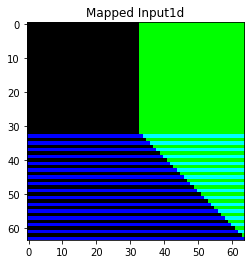

In [ ]:
#Test features_1d_to_2d

crop_x=[-32,32]
crop_y=[-32,32]

out=feature_1d_to_2d(p[0].inputs_1d,p[0].targets.residue_index.flatten(),p[0].len,crop_x,crop_y,64,64,config['network_config']['binary_code_bits'])

plt.imshow(out[:,:,:3])
plt.title("Mapped Input1d")
"""
plt.title("Vertical Crop")

fig,ax=plt.subplots()
rect = patches.Rectangle((0,crop_x[0]),p[0].inputs_1d.shape[1],64.,
                        linewidth=5, edgecolor='r', facecolor='none')
ax.add_patch(rect)    
ax.imshow(p[0].inputs_1d)
plt.title("Inputs1d Crop window")
"""


In [ ]:
print("Residue Index""0,1,2,3,4 ... 62,63")

Residue Index0,1,2,3,4 ... 62,63


## Step4: Making Inputs2d Crops
Define cropping class to get inputs 2d crops with a function get_next_crop yielding the next crop.<br>
In this function we perform following:<br>
1. Take inputs2d feature for a given protien tuple.
2. Pad inputs2d horizontally and vertically. pre and post pad size is half of crop size, each.
2. Get crop of specfied size with a calculate stride size.
3. Get diagonal horizontal and vertical crops.
4. Get augmentation features from feature_1d_to_2d.
4. Concateante horizontal,vertical diagonal, current crop and augmentation features.
5. Repeat for next crop location.


In [ ]:
#Class Cropper
class Cropper():

  #Initialize the constructor
  def __init__(self,config,protien):
    self.inputs_1d=protien.inputs_1d #Inputs1d attribute of Protien 
    self.inputs_2d=protien.inputs_2d #Inputs2d attribute of Protien
    self.L=protien.len #Sequence Length, len attribute of protien
    self.res_idx=protien.targets.residue_index.flatten() #Residue index list, like [0,1,2,...,L-1] 
    self.crop_size_x=int(config['crop_size_x']) #horizontal crop size, cols in a crop
    self.crop_size_y=config['crop_size_y'] #vertical crop size, rows in a crop
    self.crop_step_x=config['crop_size_x']//config['eval_config']['crop_shingle_x'] #hortizontal stride
    self.crop_step_y=config['crop_size_y']//config['eval_config']['crop_shingle_y'] #Vertical stride
    self.binary_code_bits=config['network_config']['binary_code_bits'] #Value from network_config dict for mapping inputs_1d to 2d


  #Get next crop
  def get_next_crop(self):
    for i in range(-self.crop_size_x // 2, self.L - self.crop_size_x // 2, self.crop_step_x):
        for j in range(-self.crop_size_y // 2, self.L - self.crop_size_y // 2, self.crop_step_y):
          
          #Get crop location stats
          end_x = i + self.crop_size_x 
          end_y = j + self.crop_size_y
          crop_x = np.array([[i, end_x]], dtype=np.int32)
          crop_y = np.array([[j, end_y]], dtype=np.int32)
          ic = max(0, i) #col index of input crop w/o prepad
          jc = max(0, j) #row index of input crop w/o prepad
          end_x_cropped = min(self.L, end_x) #col index of input crop w/o postpad
          end_y_cropped = min(self.L, end_y) #row indec of input crop w/o postpad
          prepad_x = max(0, -i) #horizontal prepad length
          prepad_y = max(0, -j) #vertical prpad length
          postpad_x = end_x - end_x_cropped #horizontal postpad length
          postpad_y = end_y - end_y_cropped #vertical postpad length

          #Get main crop
          cyx = np.pad(
                self.inputs_2d[jc:end_y, ic:end_x, :],
                [[prepad_y, postpad_y],
                [prepad_x, postpad_x],
                [0, 0]]
            )
          assert cyx.shape[0] == self.crop_size_y
          assert cyx.shape[1] == self.crop_size_x

          #Get horizontal diagonal crop
          cxx = self.inputs_2d[ic:end_x, ic:end_x, :]
          if cxx.shape[0] < cyx.shape[0]:
              cxx = np.pad(cxx,
                  [[prepad_x, max(0, i + self.crop_size_y - self.L)],
                  [prepad_x, postpad_x],
                  [0, 0]]
              )
          assert cxx.shape[0] == self.crop_size_y
          assert cxx.shape[1] == self.crop_size_x

          #Get vertical diagonal crop
          cyy = self.inputs_2d[jc:end_y, jc:end_y, :]
          if cyy.shape[1] < cyx.shape[1]:
              cyy = np.pad(cyy,
                  [[prepad_y, postpad_y],
                  [prepad_y, max(0, j + self.crop_size_x - self.L)],
                  [0, 0]]
              )
          assert cyy.shape[0] == self.crop_size_y
          assert cyy.shape[1] == self.crop_size_x

          yield cyx,crop_x,crop_y #Output for running visualization of cropper
          #Get augmentaiton features
          augmentation_features=feature_1d_to_2d(self.inputs_1d,self.res_idx,self.L,crop_x[0],crop_y[0],self.crop_size_x,
                                                 self.crop_size_y,self.binary_code_bits) #LxLx(2D+2b+1)
          
          concat_crops=np.concatenate([cyx,cxx,cyy,augmentation_features],-1) #LxLx
         # yield concat_crops,crop_x,crop_y




In [ ]:
#visualize the Cropper
"""

crop=Cropper(config,p[0])
plots=0
for cyx,crop_x,crop_y in crop.get_next_crop():
  #visualize crops
  if plots%5==0:
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow((p[0].inputs_2d[:,:,:3]* 255).astype(np.uint8))
    rect = patches.Rectangle((crop_x[0], crop_y[0]), 64., 64., linewidth=5, edgecolor='r', facecolor='none')
    ax1.add_patch(rect)
    ax1.set_title('Original 2d Feature')
    ax2.imshow((cyx[:,:,:3]* 255).astype(np.uint8))
    ax2.set_title("Crop")
    if not os.path.exists('inputs2d_crops'):
      os.makedirs('inputs2d_crops')
    f.savefig("inputs2d_crops/crop"+str(plots))
  plots+=1
  if plots==50:
    break;
  
"""


'\n\ncrop=Cropper(config,p[0])\nplots=0\nfor cyx,crop_x,crop_y in crop.get_next_crop():\n  #visualize crops\n  if plots%5==0:\n    f, (ax1, ax2) = plt.subplots(1, 2)\n    ax1.imshow((p[0].inputs_2d[:,:,:3]* 255).astype(np.uint8))\n    rect = patches.Rectangle((crop_x[0], crop_y[0]), 64., 64., linewidth=5, edgecolor=\'r\', facecolor=\'none\')\n    ax1.add_patch(rect)\n    ax1.set_title(\'Original 2d Feature\')\n    ax2.imshow((cyx[:,:,:3]* 255).astype(np.uint8))\n    ax2.set_title("Crop")\n    if not os.path.exists(\'inputs2d_crops\'):\n      os.makedirs(\'inputs2d_crops\')\n    f.savefig("inputs2d_crops/crop"+str(plots))\n  plots+=1\n  if plots==50:\n    break;\n  \n'

In [ ]:
"""
#convert images to video of crop progression
import cv2
import os
from IPython.display import FileLink

vid_fname = 'inputs2d_crops.mp4'
dir="/content/inputs2d_crops"
files = [os.path.join(dir, f) for f in os.listdir(dir) if 'crop' in f]
files.sort() #create a list of generated images


out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (432,288)) #302x302 pixels = 10x10 fake image grid
[out.write(cv2.imread(fname)) for fname in files]
out.release()
"""

'\n#convert images to video of crop progression\nimport cv2\nimport os\nfrom IPython.display import FileLink\n\nvid_fname = \'inputs2d_crops.mp4\'\ndir="/content/inputs2d_crops"\nfiles = [os.path.join(dir, f) for f in os.listdir(dir) if \'crop\' in f]\nfiles.sort() #create a list of generated images\n\n\nout = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*\'MP4V\'), 1, (432,288)) #302x302 pixels = 10x10 fake image grid\n[out.write(cv2.imread(fname)) for fname in files]\nout.release()\n'

(64, 64, 486)
(1, 2)
(1, 2)


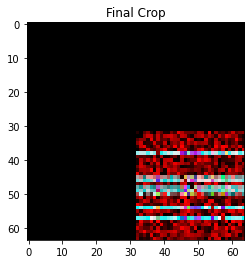

In [ ]:
#Test the cropper
c=Cropper(config,p[0])
for crop,crop_x,crop_y in c.get_next_crop():
  print(crop.shape)
  plt.imshow((crop[:,:,:3]* 255).astype(np.uint8))
  print(crop_x.shape)
  print(crop_y.shape)
  plt.title("Final Crop")
  break;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Inputs2d T0958')

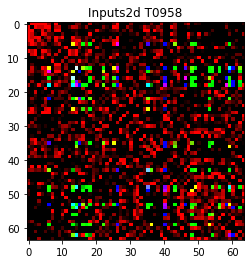

In [ ]:
plt.imshow(p[0].inputs_2d[:,:,:3])
plt.title("Inputs2d T0958")

In [ ]:
p[0].inputs_2d.shape

In [ ]:
!pip install import_ipynb

In [ ]:
!ls

In [ ]:
import import_ipynb
from Network import *

In [ ]:
%cd MyDrive/ColabNotebooks/Alphafold/

In [ ]:
# Import libraries
import numpy as np
import keras
import tensorflow as tf
from keras.models import Model
# Activation and Regularization
from keras.regularizers import l2
from keras.activations import softmax
from keras import backend as K

# Keras layers
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization, Activation, Add
#Imoprt Tensforflow and json for configuration
import json
import tensorflow as tf

# Avoid python call depth errors
import sys
sys.setrecursionlimit(5000)


In [ ]:
adam = keras.optimizers.Adam(amsgrad=True)
# Create model
model =AlphaFoldNetwork(config=config['network_config'])
model.build(input_shape=[(1,64,64,1878),(1,2),(1,2)])
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


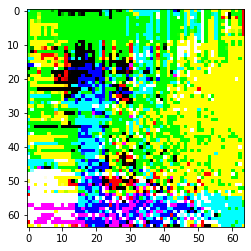

In [ ]:
#Test the cropper
c=Cropper(config,p[0])
for crop,crop_x,crop_y in c.get_next_crop():
  crop=np.expand_dims(crop,axis=0)
  out=model((crop,crop_x,crop_y))
  plt.imshow(out[0,:,:,:3])
  break;

In [ ]:
tf_ckpt='/content/alphafold-casp13-weights/873731/0/tf_graph_data/tf_graph_data.ckpt'
model.load_weights(tf_ckpt)